# Shooting Improvements, part 2

### Introduction

In the last notebook, I looked at general trends for players as they progress with their careers in the league. It's pretty clear that first year players shoot poorly as they adjust to the league. 

But what if zoom in closer? I want to find out what the data looks like if we separate players by how good they are at shooting to begin with. If you can't hit a threshold of 3pt shooting percentage early in your career, are you doomed to be a bad shooter? 

If you start off strong, will you just keep rising as a shooter or will you tail off quickly as you hit a limit?

In [2]:
from nba_api.stats.endpoints import commonplayerinfo, playerdashboardbyyearoveryear, commonteamroster
from nba_api.stats.static import players, teams
import time
import pandas as pd
import numpy as np
import math

import warnings
warnings.filterwarnings("ignore")

In [3]:
player_data = pd.read_csv("total_player_stats_by_year.csv")
experienced_players = player_data[player_data["max_experience"] > 4]
qualified_players = experienced_players[experienced_players["FG3A"] > 120]
qualified_players.head(10)

,Unnamed: 0,GROUP_VALUE,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,BLK,PTS,PLUS_MINUS,experience,PLAYER_NAME,PLAYER_ID,age,yr,adj_age,max_experience
10,10,2012-13,82,2639.955000,396,897,0.441,87,257,0.339,...,29,1095,133,2,Jeremy Lin,202391,30,2012,24,8
11,11,2013-14,71,2054.025000,295,662,0.446,82,229,0.358,...,27,890,175,3,Jeremy Lin,202391,30,2013,25,8
12,12,2014-15,74,1906.723333,277,654,0.424,65,176,0.369,...,32,832,-253,4,Jeremy Lin,202391,30,2014,26,8
13,13,2015-16,78,2047.555000,300,728,0.412,76,226,0.336,...,42,914,84,5,Jeremy Lin,202391,30,2015,27,8
14,14,2016-17,36,882.588333,175,400,0.438,58,156,0.372,...,14,523,-83,6,Jeremy Lin,202391,30,2016,28,8
26,26,2017-18,62,1542.273333,250,477,0.524,50,141,0.355,...,51,617,-158,4,Dewayne Dedmon,203473,29,2017,28,5
29,29,1999-00,82,3127.983333,788,1696,0.465,95,236,0.403,...,92,2107,181,1,Vince Carter,1713,41,1999,22,20
30,30,2000-01,75,2980.056667,762,1656,0.460,162,397,0.408,...,82,2070,323,2,Vince Carter,1713,41,2000,23,20
31,31,2001-02,60,2385.645000,559,1307,0.428,121,313,0.387,...,45,1484,68,3,Vince Carter,1713,41,2001,24,20
32,32,2002-03,43,1470.348333,355,760,0.467,45,131,0.344,...,41,884,-27,4,Vince Carter,1713,41,2002,25,20


In [20]:
# Finding the players who started their careers as bad shooters
early_years = qualified_players[qualified_players['experience'] < 3]
early_years_combined = early_years.groupby('PLAYER_ID')['FG3_PCT'].max().reset_index()
bad_early = early_years_combined[early_years_combined['FG3_PCT'] < 0.340] # Under 25th percentile

bad_early['BAD_EARLY'] = True
bad_early.pop('FG3_PCT')

bad_early_full = pd.merge(qualified_players, bad_early, on='PLAYER_ID', how='right')
bad_early_full.head(10)


,Unnamed: 0,GROUP_VALUE,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,PTS,PLUS_MINUS,experience,PLAYER_NAME,PLAYER_ID,age,yr,adj_age,max_experience,BAD_EARLY
0,10,2012-13,82,2639.955000,396,897,0.441,87,257,0.339000,...,1095,133,2,Jeremy Lin,202391,30,2012,24,8,True
1,11,2013-14,71,2054.025000,295,662,0.446,82,229,0.358000,...,890,175,3,Jeremy Lin,202391,30,2013,25,8,True
2,12,2014-15,74,1906.723333,277,654,0.424,65,176,0.369000,...,832,-253,4,Jeremy Lin,202391,30,2014,26,8,True
3,13,2015-16,78,2047.555000,300,728,0.412,76,226,0.336000,...,914,84,5,Jeremy Lin,202391,30,2015,27,8,True
4,14,2016-17,36,882.588333,175,400,0.438,58,156,0.372000,...,523,-83,6,Jeremy Lin,202391,30,2016,28,8,True
5,315,2014-15,82,2380.963333,251,634,0.396,68,208,0.327000,...,729,-180,1,Solomon Hill,203524,27,2014,23,5,True
6,317,2016-17,80,2374.301667,183,478,0.383,94,270,0.348000,...,563,5,3,Solomon Hill,203524,27,2016,25,5,True
7,348,2015-16,106,1545.173333,176,456,0.376,72,210,0.332667,...,478,-178,2,Justin Holiday,203200,29,2015,26,5,True
8,349,2016-17,82,1639.123333,233,538,0.433,97,273,0.355000,...,629,-41,3,Justin Holiday,203200,29,2016,27,5,True
9,350,2017-18,72,2264.925000,290,782,0.371,161,449,0.359000,...,876,-180,4,Justin Holiday,203200,29,2017,28,5,True


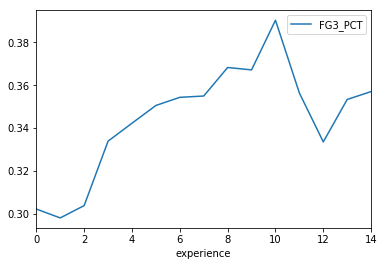

In [21]:
grouped_bad_shooters = bad_early_full.groupby('experience')['FG3_PCT'].mean().reset_index()
grouped_bad_shooters.plot.line(x='experience', y='FG3_PCT')

In [25]:
# Finding the players who started their careers as bad shooters
# early_years = qualified_players[qualified_players['experience'] < 3]
# early_years_combined = early_years.groupby('PLAYER_ID')['FG3_PCT'].max().reset_index()
medium_early = early_years_combined[early_years_combined['FG3_PCT'].between(0.340, 0.377)] # Between 25th and 75th percentile

medium_early['MEDIUM_EARLY'] = True
medium_early.pop('FG3_PCT')

medium_early_full = pd.merge(qualified_players, medium_early, on='PLAYER_ID', how='right')
medium_early_full.head(10)

239

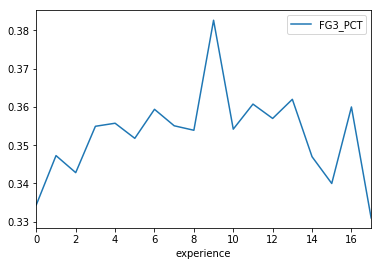

In [26]:
grouped_medium_shooters = medium_early_full.groupby('experience')['FG3_PCT'].mean().reset_index()
grouped_medium_shooters.plot.line(x='experience', y='FG3_PCT')

In [28]:
good_early = early_years_combined[early_years_combined['FG3_PCT'] > 0.377] # Between 25th and 75th percentile

good_early['GOOD_EARLY'] = True
good_early.pop('FG3_PCT')

good_early_full = pd.merge(qualified_players, good_early, on='PLAYER_ID', how='right')
good_early_full.head(10)

393

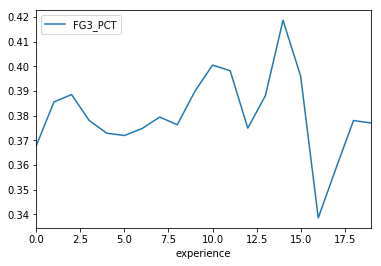

In [29]:
grouped_good_shooters = good_early_full.groupby('experience')['FG3_PCT'].mean().reset_index()
grouped_good_shooters.plot.line(x='experience', y='FG3_PCT')

In [30]:
qualified_players.head(10)

,Unnamed: 0,GROUP_VALUE,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,BLK,PTS,PLUS_MINUS,experience,PLAYER_NAME,PLAYER_ID,age,yr,adj_age,max_experience
10,10,2012-13,82,2639.955000,396,897,0.441,87,257,0.339,...,29,1095,133,2,Jeremy Lin,202391,30,2012,24,8
11,11,2013-14,71,2054.025000,295,662,0.446,82,229,0.358,...,27,890,175,3,Jeremy Lin,202391,30,2013,25,8
12,12,2014-15,74,1906.723333,277,654,0.424,65,176,0.369,...,32,832,-253,4,Jeremy Lin,202391,30,2014,26,8
13,13,2015-16,78,2047.555000,300,728,0.412,76,226,0.336,...,42,914,84,5,Jeremy Lin,202391,30,2015,27,8
14,14,2016-17,36,882.588333,175,400,0.438,58,156,0.372,...,14,523,-83,6,Jeremy Lin,202391,30,2016,28,8
26,26,2017-18,62,1542.273333,250,477,0.524,50,141,0.355,...,51,617,-158,4,Dewayne Dedmon,203473,29,2017,28,5
29,29,1999-00,82,3127.983333,788,1696,0.465,95,236,0.403,...,92,2107,181,1,Vince Carter,1713,41,1999,22,20
30,30,2000-01,75,2980.056667,762,1656,0.460,162,397,0.408,...,82,2070,323,2,Vince Carter,1713,41,2000,23,20
31,31,2001-02,60,2385.645000,559,1307,0.428,121,313,0.387,...,45,1484,68,3,Vince Carter,1713,41,2001,24,20
32,32,2002-03,43,1470.348333,355,760,0.467,45,131,0.344,...,41,884,-27,4,Vince Carter,1713,41,2002,25,20


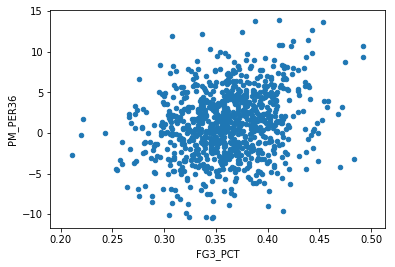

In [31]:
qf = experienced_players[experienced_players["FG3A"] > 120]
qf['PM_PER36'] = 36 * (qf['PLUS_MINUS'] / qf['MIN'])

qf.plot.scatter(x='FG3_PCT', y='PM_PER36')

In [34]:
import seaborn as sns

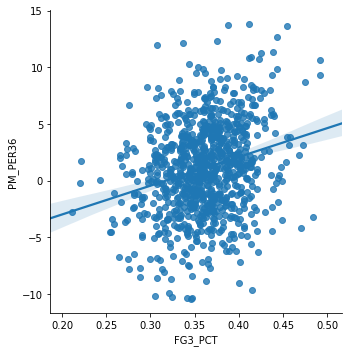

In [35]:
sns.lmplot(x='FG3_PCT',y='PM_PER36',data=qf,fit_reg=True) 


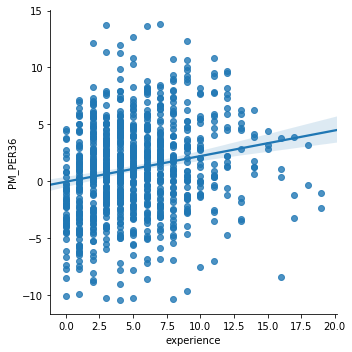

In [36]:
sns.lmplot(x='experience',y='PM_PER36',data=qf,fit_reg=True) 


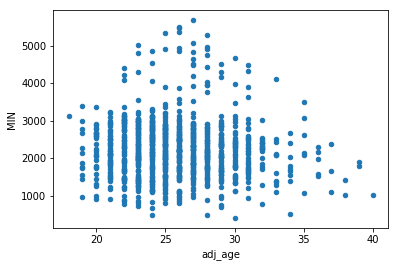

In [39]:
qf.plot.scatter(x='adj_age', y='MIN')